In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import tensorflow as tf

In [2]:
imstack = np.load('tiles.npy', allow_pickle=True)
# imstack = imstack[...,np.newaxis]
print(imstack.shape)

(40400, 128, 128)


Number of components explaining 95% variance: 32


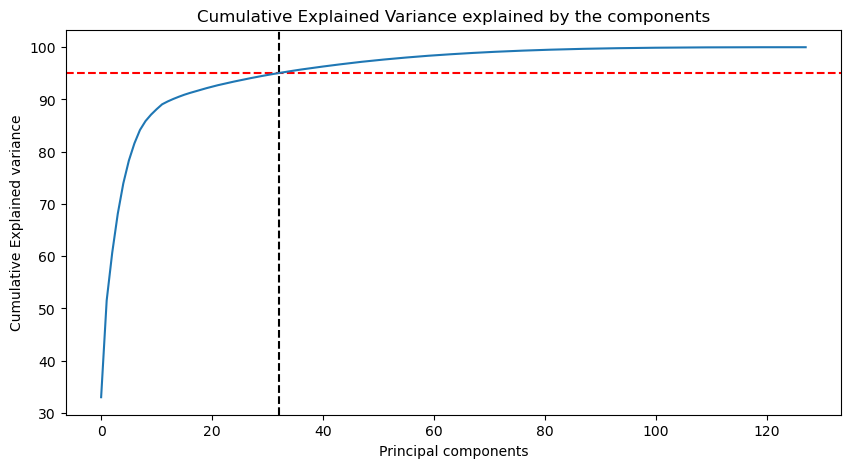

In [3]:
from sklearn.decomposition import PCA, IncrementalPCA
pca = PCA()
pca.fit(imstack[1])

# Getting the cumulative variance

var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))
#print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

When looking at the first image of imstack, from 16384 pixels (128 x 128), **32** components can explain variance in the image. However, We must remember that PCA is a linear method and we would prefer to capture non-linear patterns in image data. Lets see what the spread looks like throughout the entire top_view dataset

In [4]:
components = []
for im in range(len(imstack)):
    pca = PCA()
    pca.fit(imstack[im])
    
    var_cumu = np.cumsum(pca.explained_variance_ratio_)*100
    k = np.argmax(var_cumu > 95)
    components.append(k)

In [5]:
from pandas import DataFrame

df = DataFrame(components)
df = df.rename(columns={0:'K_components'})

In [6]:
df.describe()

,K_components
count,40400.000000
mean,9.670743
std,3.733340
min,1.000000
25%,7.000000
50%,9.000000
75%,11.000000
max,58.000000


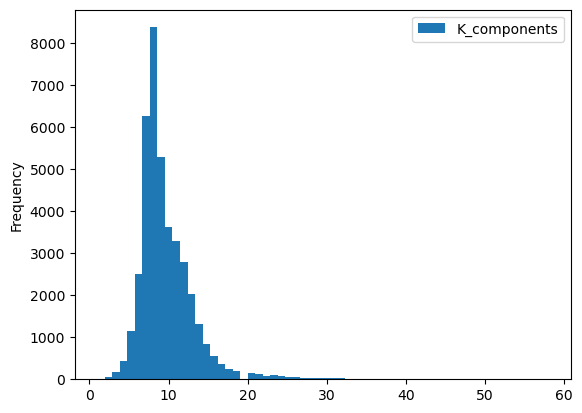

In [11]:
df.plot.hist(bins=60, grid=False).get_figure().savefig('K_components_explaining_variance.png')

From this PCA reduction, we find that the number of components (K) needed to explain the most important features can be explained of images in the *top_view* dataset is positively skewed around 8 (mode) / 9.7 (mean) for images of (128px by 128px) . Therefore, we could set the latent dimension to this reduced dimensionality.

<function matplotlib.pyplot.show(close=None, block=None)>

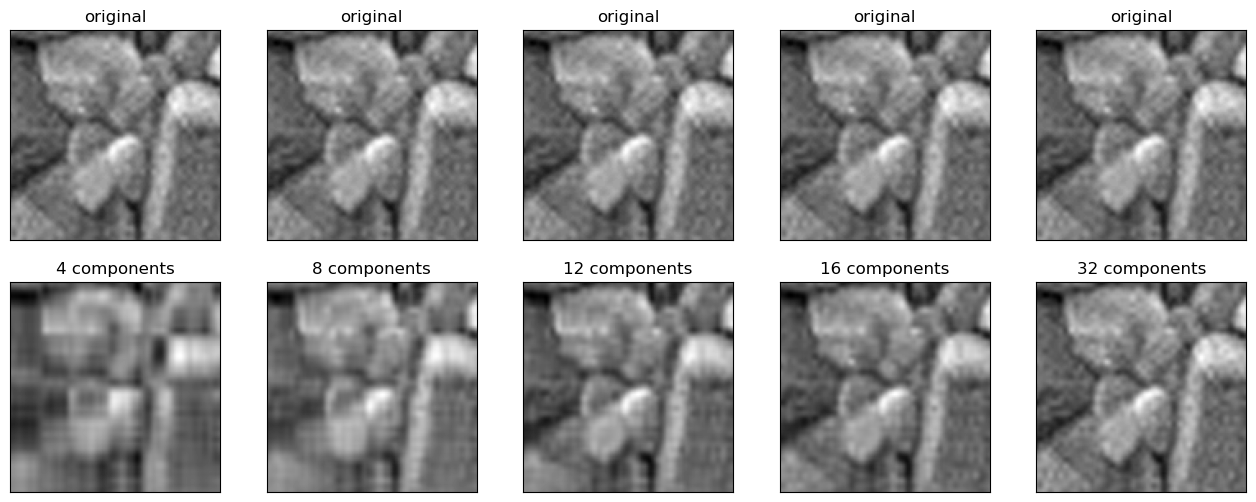

In [12]:
comp = [4,8,12,16,32]
im = np.random.randint(0, len(imstack)-1)

plt.figure(figsize=(16, 6))
for k in range(len(comp)):
    ipca = IncrementalPCA(n_components= comp[k])
    imstack_recon = ipca.inverse_transform(ipca.fit_transform(imstack[im]))
    
    # display original
    ax = plt.subplot(2, len(comp), k + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(imstack[im]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #display reconstruction
    bx = plt.subplot(2, len(comp), k + len(comp) + 1)
    plt.title(f"{comp[k]} components")
    plt.imshow(imstack_recon)
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show

Using PCA, we can see the effect of increasing the number of components with image reconstruction. At the lower end, the loss in quality is high and increases with added components. Contrarily, on the higher end, there is visually little difference reconstructed images. So we can assume that a good latent space dimension for the VAE would be around 12, not 8/9.

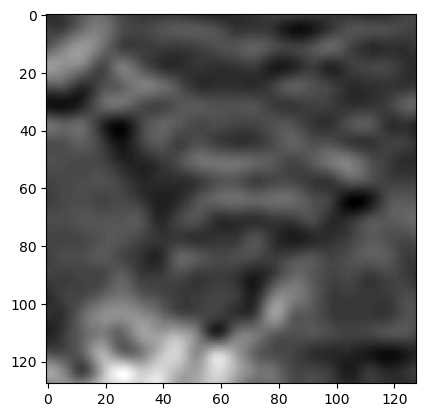

In [9]:
plt.imshow(imstack_recon)

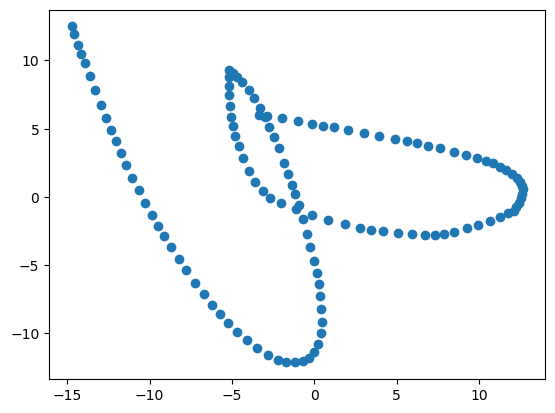

In [10]:
from sklearn.manifold import TSNE
n_components = 3 # since images are single channel

tsne = TSNE(n_components= n_components, perplexity= 4, random_state= 48)
imstack_reduced_tsne = tsne.fit_transform(imstack_recon)
plt.scatter(imstack_reduced_tsne[:,0],imstack_reduced_tsne[:,1])

Inspiration from:

- https://www.kaggle.com/code/mirzarahim/introduction-to-pca-image-compression-example
- https://www.kaggle.com/code/hamishdickson/preprocessing-images-with-dimensionality-reduction
- https://www.tensorflow.org/tutorials/generative/autoencoder#second_example_image_denoising